In [26]:
# librerías
import os
import json
import hashlib
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Fase 1: Análisis Exploratorio de Datos (EDA)

### 1.1. Análisis Descriptivo y Versionado Inicial de Datos

In [27]:
# verificamos la ruta de los datos y si se encuentran ahi
data_path = '../data'
excel_files = glob.glob(os.path.join(data_path, '*.xlsx'))
print(f'Archivos encontrados: {len(excel_files)}')
print(excel_files)

Archivos encontrados: 3
['../data\\Totalizadores Planta de Cerveza - 2022_2023.xlsx', '../data\\Totalizadores Planta de Cerveza 2021_2022.xlsx', '../data\\Totalizadores Planta de Cerveza 2023_2024.xlsx']


In [28]:
# aca vamos a leer los archivos y a unificar la hoja 'Consolidado EE' de todos los archivos, que es donde está nuestra variable objetivo 'Frio(Kw)'
target_sheet_name = 'Consolidado EE'
data_frame = []

for file in excel_files:
    try:
        df_sheet = pd.read_excel(file, sheet_name=target_sheet_name)
        data_frame.append(df_sheet)
        print(f'Hoja {target_sheet_name} leída correctamente de {os.path.basename(file)}')
    except Exception as e:
        print(f'Error al leer {target_sheet_name} de {os.path.basename(file)}: {e}')

# concatenamos todos los dataframes en uno solo
if data_frame:
    df_unified_raw = pd.concat(data_frame, ignore_index=True)
    print(f'Dataframe unificado creado con {df_unified_raw.shape[0]} filas y {df_unified_raw.shape[1]} columnas.')
    # mostramos las primeras filas del dataframe unificado
    print('\nPrimeras filas del dataframe unificado:')      
    print(df_unified_raw.head())
    # mostramos la info del dataframe unificado
    print('\nInformación del dataframe unificado:')
    print(df_unified_raw.info())
else:
    print('No se pudieron leer datos de los archivos proporcionados.')
    df_unified_raw = pd.DataFrame()  # aca creamos un dataframe vacio para evitar errores posteriores

# guardamos el dataframe unificado en un archivo csv para facilitar su uso posterior
output_csv_path = os.path.join(data_path, 'df_unified_raw.csv')
df_unified_raw.to_csv(output_csv_path, index=False)
print(f'Dataframe unificado guardado en {output_csv_path}')

Hoja Consolidado EE leída correctamente de Totalizadores Planta de Cerveza - 2022_2023.xlsx
Hoja Consolidado EE leída correctamente de Totalizadores Planta de Cerveza 2021_2022.xlsx
Hoja Consolidado EE leída correctamente de Totalizadores Planta de Cerveza 2023_2024.xlsx
Dataframe unificado creado con 43515 filas y 24 columnas.

Primeras filas del dataframe unificado:
         DIA      HORA  Planta (Kw)  Elaboracion (Kw)  Bodega (Kw)  \
0 2022-07-01  02:00:00      1368.76              46.0        101.5   
1 2022-07-01  03:00:00      2765.64              93.0        203.5   
2 2022-07-01  04:00:00      4124.46             141.0        306.0   
3 2022-07-01  05:00:01      5419.31             182.5        401.5   
4 2022-07-01  06:00:01      6673.19             228.0        499.0   

   Cocina (Kw)  Envasado (Kw)  Linea 2 (Kw)  Linea 3 (Kw)  Linea 4 (Kw)  ...  \
0          7.0           12.0         30.01          42.0           0.0  ...   
1         13.0           26.0         59.64     

In [29]:
# ahora procedemos a calcular y guardar el checksum inicial
if not df_unified_raw.empty:
    datetime_col = 'DIA'
    if datetime_col in df_unified_raw.columns:
        df_unified_raw[datetime_col] = pd.to_datetime(df_unified_raw[datetime_col])
        df_unified_raw = df_unified_raw.sort_values(by=datetime_col).reset_index(drop=True)
        print(f'\n Dataframe ordenado por la columna {datetime_col}.')
    else:
        print(f'\n La columna {datetime_col} no existe en el dataframe y por lo tanto no se pudo ordenar.')

    # convertimos a bytes para hashear
    data_bytes = df_unified_raw.to_csv(index=False).encode()
    checksum_initial = hashlib.md5(data_bytes).hexdigest()

    checksum_file_path = os.path.join(data_path, 'checksums.json')
    checksums = {
        'initial_consolidado_ee': checksum_initial
    }

    try:
        with open(checksum_file_path, 'w') as f:
            json.dump(checksums, f, indent=4)
        print(f"\nChecksum inicial '{checksum_initial}' guardado en '{checksum_file_path}'")
    except Exception as e:
        print(f"\nError guardando checksum: {e}")
else:
    print("\nDataFrame vacío, no se calculó el checksum.")


 Dataframe ordenado por la columna DIA.

Checksum inicial '2deec2995b8a8a2cd622190332a4be6a' guardado en '../data\checksums.json'


In [30]:
# pasamos a la agregación diaria combinando DIA y HORA

df_unified_raw['Fecha_DT_Temp'] = df_unified_raw['DIA'].dt.date # Usamos nombre temporal

# convertimos 'HORA' a timedelta, para así manejar errores
df_unified_raw['Hora_TD_Temp'] = pd.to_timedelta(df_unified_raw['HORA'].astype(str), errors='coerce')

# identificamos filas con horas inválidas
invalid_hours = df_unified_raw['Hora_TD_Temp'].isna()
if invalid_hours.any():
    print(f"Se encontraron {invalid_hours.sum()} valores inválidos en 'HORA'. Estas filas serán excluidas de la agregación.")

# combinamos Fecha_DT_Temp y Hora_TD_Temp para crear el timestamp completo y preciso
# convertimos Fecha_DT_Temp a datetime completo (a medianoche) antes de sumar
df_unified_raw['Timestamp_Completo_Temp'] = pd.to_datetime(df_unified_raw['Fecha_DT_Temp']) + df_unified_raw['Hora_TD_Temp']

# lógica para obtener el registro de la última hora de cada día
# primero, filtramos filas con timestamps inválidos
df_valid = df_unified_raw.dropna(subset=['Fecha_DT_Temp', 'Timestamp_Completo_Temp']).copy()
if df_valid.shape[0] < df_unified_raw.shape[0]:
     print(f"Se procesarán {df_valid.shape[0]} filas con timestamps válidos (excluyendo {df_unified_raw.shape[0] - df_valid.shape[0]} inválidas).")

# ahora, para cada día, obtenemos el índice del registro con el timestamp máximo (última hora)
idx_ultimas_horas = df_valid.groupby('Fecha_DT_Temp')['Timestamp_Completo_Temp'].idxmax()
print(f"Se identificaron {len(idx_ultimas_horas)} días únicos con registros válidos.")

# usamos estos índices para crear el dataframe diario final
df_diario = df_valid.loc[idx_ultimas_horas].reset_index(drop=True)

# creamos la columna 'Fecha' como datetime y la establecemos como índice
df_diario['Fecha'] = pd.to_datetime(df_diario['Fecha_DT_Temp'])
df_diario = df_diario.set_index('Fecha')

# eliminamos las columnas temporales y las originales 'DIA' y 'HORA'
columns_to_drop_final = ['DIA', 'HORA', 'Fecha_DT_Temp', 'Hora_TD_Temp', 'Timestamp_Completo_Temp', 'Fecha/Hora','Kw de Frio']
df_diario = df_diario.drop(columns=[col for col in columns_to_drop_final if col in df_diario.columns], errors='ignore')

# Lista de columnas a eliminar
columnas_a_borrar = [
    "Fecha/Hora",
    "Kw de Frio"
]


daily_csv_path = os.path.join(data_path, 'df_daily.csv')
try:
    df_diario.to_csv(daily_csv_path, decimal='.') 
    print(f"\nDataFrame diario guardado en '{daily_csv_path}'")
except Exception as e:
    print(f"\nError guardando DataFrame diario: {e}")



Se encontraron 615 valores inválidos en 'HORA'. Estas filas serán excluidas de la agregación.
Se procesarán 42900 filas con timestamps válidos (excluyendo 615 inválidas).
Se identificaron 1199 días únicos con registros válidos.

DataFrame diario guardado en '../data\df_daily.csv'


In [31]:
# dimensiones del dataframe diario
# leemos el dataframe diario
df_daily = pd.read_csv(daily_csv_path, dtype=str)
print(f'\nDataframe diario creado con {df_daily.shape[0]} filas y {df_daily.shape[1]} columnas.')
print('\nPrimeras filas del dataframe diario:')
print(df_daily.head())


Dataframe diario creado con 1199 filas y 21 columnas.

Primeras filas del dataframe diario:
        Fecha Planta (Kw) Elaboracion (Kw) Bodega (Kw) Cocina (Kw)  \
0  2021-01-01    39118.47           3165.0      3244.5       535.0   
1  2021-01-02    42469.62          4185.75     4226.25       783.0   
2  2021-01-03    18495.36           1946.0      2198.5       478.0   
3  2021-01-04    25943.96          4865.25     3024.25      2541.0   
4  2021-01-05     38016.7           4831.5      6317.5      2343.0   

  Envasado (Kw) Linea 2 (Kw) Linea 3 (Kw) Linea 4 (Kw) Servicios (Kw)  ...  \
0       11726.0      6767.22       6898.0        463.0        21831.0  ...   
1       11932.0      7009.75       6889.0        459.0        23629.0  ...   
2        3643.0      1883.24       2349.0        336.0        13209.0  ...   
3        1472.0      1031.46        490.0          0.0        19519.0  ...   
4        3781.0      5419.45       3518.0          0.0        23994.0  ...   

  Aire (Kw) Calde

In [32]:
# info del dataframe diario
print('\nInformación del dataframe diario:')
print(df_daily.info())


Información del dataframe diario:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Fecha                 1199 non-null   object
 1   Planta (Kw)           1199 non-null   object
 2   Elaboracion (Kw)      1199 non-null   object
 3   Bodega (Kw)           1199 non-null   object
 4   Cocina (Kw)           1199 non-null   object
 5   Envasado (Kw)         1199 non-null   object
 6   Linea 2 (Kw)          1199 non-null   object
 7   Linea 3 (Kw)          1199 non-null   object
 8   Linea 4 (Kw)          1199 non-null   object
 9   Servicios (Kw)        1199 non-null   object
 10  Sala Maq (Kw)         1199 non-null   object
 11  Aire (Kw)             1199 non-null   object
 12  Calderas (Kw)         1199 non-null   object
 13  Efluentes (Kw)        1199 non-null   object
 14  Frio (Kw)             1199 non-null   object
 15  Pta

In [33]:
print('\nDescripción estadística del dataframe diario:')
print(df_daily.describe().T)


Descripción estadística del dataframe diario:
                     count unique                top freq
Fecha                 1199   1199         2021-01-01    1
Planta (Kw)           1199   1199           39118.47    1
Elaboracion (Kw)      1199   1155             5783.0    3
Bodega (Kw)           1199   1151             8612.0    3
Cocina (Kw)           1199    899             2231.0    5
Envasado (Kw)         1199   1145            17493.0    3
Linea 2 (Kw)          1199   1199            6767.22    1
Linea 3 (Kw)          1199   1015             7692.0    5
Linea 4 (Kw)          1199    807                0.0  119
Servicios (Kw)        1199   1177            40323.0    2
Sala Maq (Kw)         1199   1170            32089.0    2
Aire (Kw)             1199   1047             5899.0    4
Calderas (Kw)         1199    607                0.0   35
Efluentes (Kw)        1199    600              702.0    8
Frio (Kw)             1199   1176            26888.0    2
Pta Agua / Eflu (Kw)  119

In [34]:
# valores faltantes
missing_values_daily = df_daily.isna().sum()
missing_percentage_daily = (df_daily.isna().mean() * 100).round(2)
missing_info_daily = pd.DataFrame({'count': missing_values_daily, 'percentage': missing_percentage_daily})
print(missing_info_daily[missing_info_daily['count'] > 0])

        count  percentage
KW CO2    470        39.2


### 1.2. Análisis Temporal

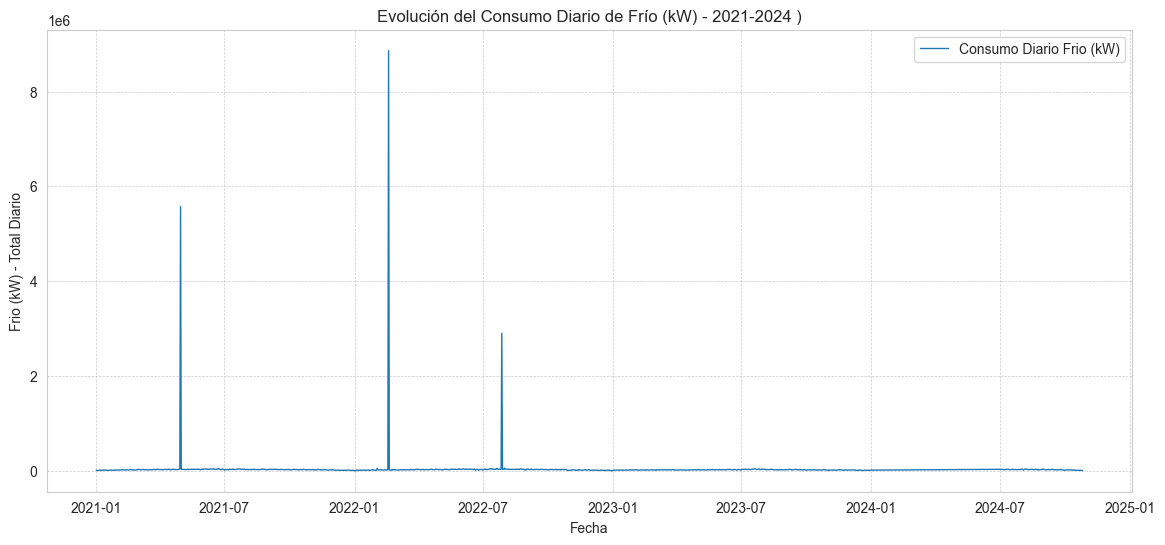

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo y tamaño
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

plt.figure()
# Usamos el índice (Fecha) para el eje X
plt.plot(df_diario.index, df_diario['Frio (Kw)'], label='Consumo Diario Frio (kW)', linewidth=1)
plt.title('Evolución del Consumo Diario de Frío (kW) - 2021-2024 )')
plt.xlabel('Fecha')
plt.ylabel('Frio (kW) - Total Diario')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()